In [1]:
import numpy as np
import sys
sys.path.insert(1,'../../src')
from _generate_time_series import *
from _shear_frame import *
from utils_OB import *
from _clustering import *
import _tracking as tk
from utils_JK import *
import seaborn as sns
sns.set_theme(context='paper',font_scale=1.0, style = 'ticks', color_codes='deep')

%load_ext autoreload
%autoreload 2

#### Setting up the initial system:

In [2]:
# stiffness and mass: 
kx=np.array([2,2])*4000
ky=kx
m=np.array([1,1])*500

#### Specify the development with time

Text(70, 1.1, ' ')

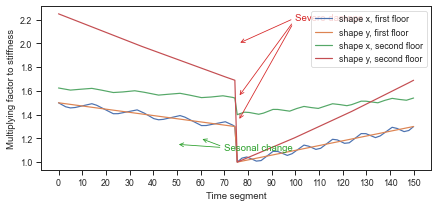

In [21]:
n=150  #number of time series to run

#shapes for how the stiffnesses should behave trougout the time series:
base_shapey=np.hstack((np.linspace(1.5,1.3,n//2),np.linspace(1,1.3,n-n//2)))
base_shapex=np.sin(2*np.pi*base_shapey*20)*0.03+base_shapey

shapey=np.vstack((base_shapey,base_shapey**2))
shapex=np.vstack((base_shapex,base_shapex**0.5+0.4))

fig,ax = plt.subplots(figsize=(7,3))
ax.plot(np.linspace(0,n,n),shapex[0],label='shape x, first floor')
ax.plot(np.linspace(0,n,n),shapey[0], label='shape y, first floor')
ax.plot(np.linspace(0,n,n),shapex[1],label='shape x, second floor')
ax.plot(np.linspace(0,n,n),shapey[1], label='shape y, second floor')
ax.set_xlabel('Time segment')
ax.set_xticks(np.arange(0, 151, 10))
ax.set_ylabel('Multiplying factor to stiffness')
ax.legend()

ax.annotate('Severe damage',xy=(75, 2),xytext=(100, 2.2), color ='tab:red')
ax.annotate(text = ' ',xy=(76, 2), xytext=(100, 2.2),
            arrowprops=dict(arrowstyle='->', color='tab:red'))
ax.annotate(text = ' ',xy=(76, 1.55), xytext=(100, 2.2),
            arrowprops=dict(arrowstyle='->', color='tab:red'))
ax.annotate(text = ' ',xy=(76, 1.35), xytext=(100, 2.2),
            arrowprops=dict(arrowstyle='->', color='tab:red'))

ax.annotate('Sesonal change',xy=(40, 1.3),xytext=(70, 1.1), color = 'tab:green')
ax.annotate(text = ' ',xy=(50, 1.15), xytext=(70, 1.1),
            arrowprops=dict(arrowstyle='->', color='tab:green'))
ax.annotate(text = ' ',xy=(60, 1.2), xytext=(70, 1.1),
            arrowprops=dict(arrowstyle='->', color='tab:green'))


#fig.savefig('./figures/mode_evolution', dpi = 300, bbox_inches = 'tight')

#### Defining the time series and modal orders

In [22]:
#What modal orders to run in the cov-ssi:
orders=np.arange(2,50,1)

#sampling frequency and lengt of each time series:
fs = 7        #Hz
T_max=3000  #sec
t=np.arange(0,T_max,1/fs)

#### Specifing the load
        If none of [next_segment,next_DOF,harmonic,harmonic_part] is 
        specified the same white noise loading are used for all
        DOFs, for all the time series.  
        
        next_segment: 'new' or'same'
                whether or not to creata a new set of loads 
                for each time segment
                
        next_DOF: 'new','same' or 'random'
                whether or not to create a new set of loading for each
                DOF. 'same' uses the same load series, new creates a new
                series with same parameters, randaom creates random params.
                as well.
        white_noise_amp: float
                the relative amplitude of the white noise 

        harmonic: string or None
            'random' crates a random freq. in the interval [0.5w_0,2w_n] w 
            are natural frqs of the frame.
            'decreasing' creates a decreasing frequenzy from [w_n , w_0]

        harmonic_part: float
            the harmonic amplitude in relation to the white noise. 0.5
            gives 50% of the amplitude.

In [23]:
# specify parameters for the load series: 
    # the general input for the amplutide of the white noise
white_noise_amp=1
    # whether or not to create new load series for each time segment
next_segment='new'
    #whether or not to greate indeviduel loadings for all DOFS
next_DOF='new'
    #Whether or not to include a harmonic part in the loading, and what type of 
    #harmonic function
harmonic=None
    #the the factor the amplitude of the harmonic is multiplied with 
    #the amplitude of the white noise
harmonic_part=0.2

### Noise fac for added measurments noice: 
noise_fac=0.2

## Generating the time series

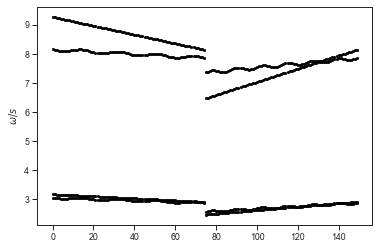

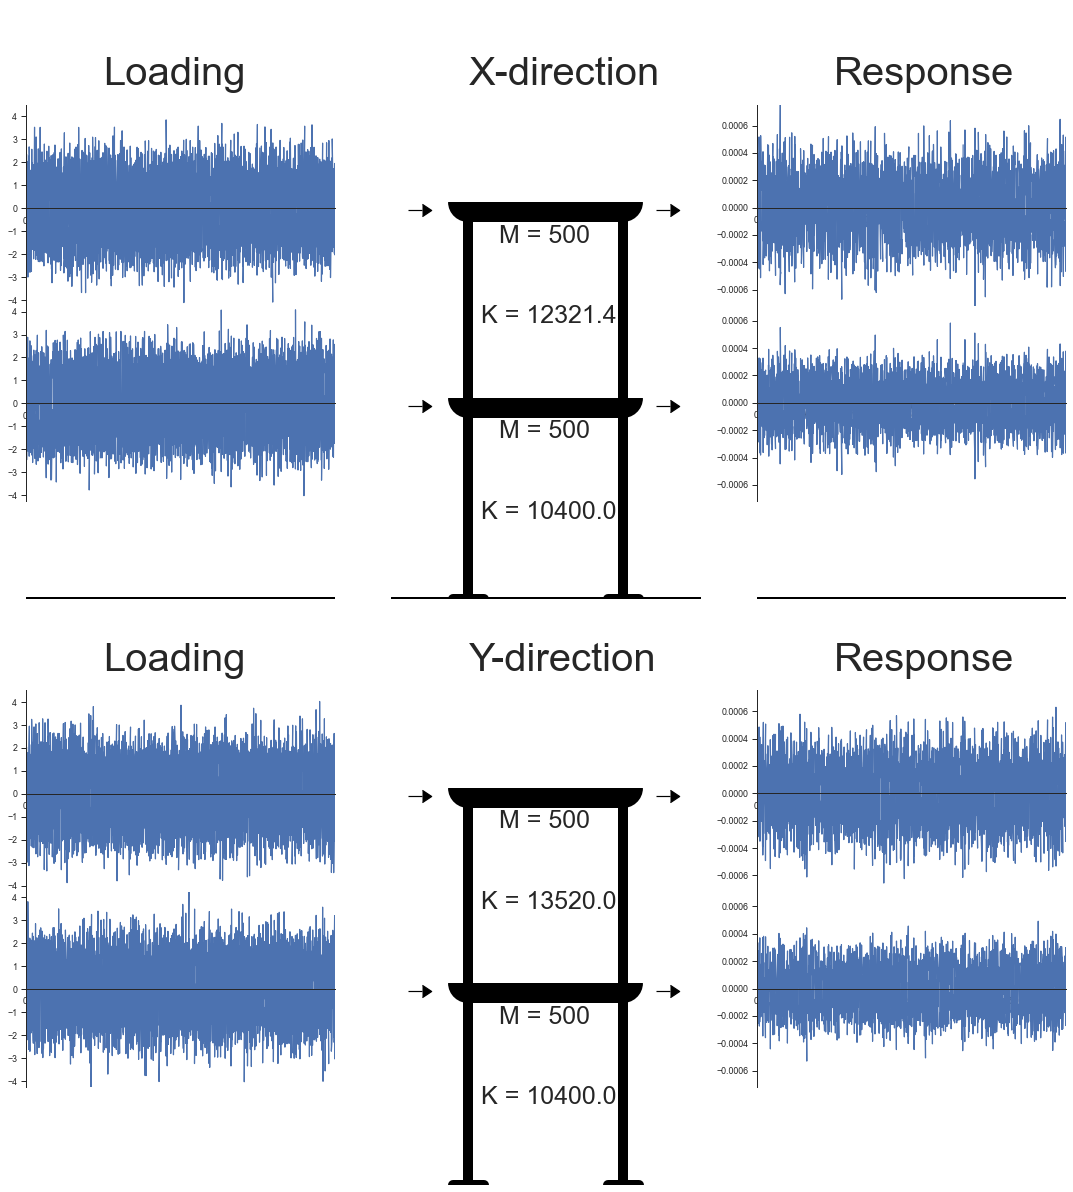

In [24]:
true_w,true_phi,responses=generate_dynamic_series(kx,ky,shapex,shapey,m,t,
                                           white_noise_amp=white_noise_amp
                                           ,next_segment=next_segment
                                           ,next_DOF=next_DOF
                                           ,harmonic=harmonic
                                           ,harmonic_part=harmonic_part
                                           ,plot=True)

In [25]:
np.savez('test_3_true_new',true_w,true_phi)

In [9]:
data_true = np.load('test_3_true.npz',allow_pickle=True)
true_w = data_true['arr_0']
true_phi = data_true['arr_1']

#### Running cov-ssi:

In [7]:
lambds,phis=create_input_COVssi(responses,t,orders)

#### Plotting each time segment as a column

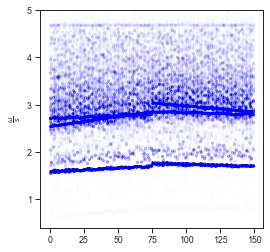

In [8]:
matplotlib.use('module://matplotlib_inline.backend_inline') #setting backend in case cells are not run in appropriate order
ys=create_output_guassian(lambds)

til_jon=ys.T

plt.figure(figsize=(4,4))
for k,s in enumerate(ys): 
    plt.scatter(s*0+k,s,s=6,alpha=0.005,color='blue')
plt.ylim(0.4,5)
plt.ylabel(r"$\frac{\omega}{s}$")
plt.show()

# plt.figure(figsize=(10,10))
# for k,s in enumerate(ys): 
#     plt.scatter(s*0+k,s,s=6,alpha=0.02,color='blue')
#     plt.scatter(true_w[k]*0+k,true_w[k],color='black',marker=1)
# plt.ylim(0.4,3.6)

#### Setting the parameters for the clustering

In [9]:
valid_range= { 'freq': [1e-4, np.inf],'damping': [1e-4,np.inf] }

indicator='freq'
s=3
stabcrit = {'freq':0.05, 'damping': 1, 'mac': 0.1}

prob_threshold = 0.9   #probability of pole to belong to 
# cluster, based on estimated "probability" density function
min_cluster_size = 25
min_samples = 20
scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0}


#### Clustering: 

In [10]:
phis_out,ws_out=clustering(lambds,
phis,orders,s,stabcrit,valid_range,indicator,prob_threshold,
scaling,min_cluster_size,min_samples,true_w=true_w,plot=True)

#### Plotting the output, aka the test case:

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\jonkr\AppData\Local\Temp/ipykernel_2080/613402569.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.abs(w_i)**1/2/np.pi,color='black',s=2)


ValueError: setting an array element with a sequence.

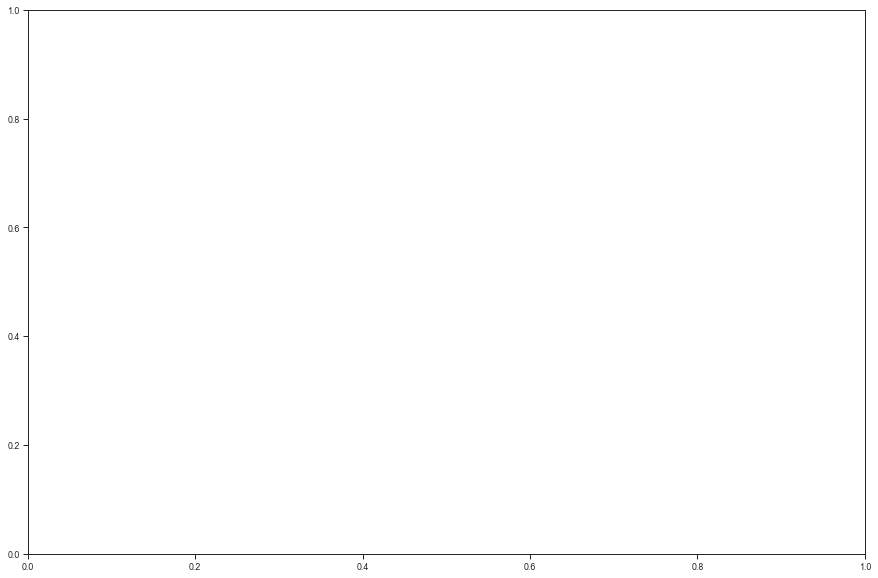

: 

In [12]:
matplotlib.use('module://matplotlib_inline.backend_inline') #setting backend in case cells are not run in appropriate order

fig,ax =plt.subplots(figsize=(15,10))
for segment_number,w_i in enumerate(ws_out):
    ax.scatter(np.ones_like(w_i)*segment_number,
               np.abs(w_i)**1/2/np.pi,color='black',s=2)
    #ax.set_title('poles left atfer clustering')
    ax.set_xlabel('Time Segment')
    ax.set_ylabel('Frequency [Hz]')
plt.show()

In [35]:
np.savez('test_3',np.array(ws_out,dtype=object),
         np.array(phis_out,dtype=object))

### Analyze results

In [36]:
data = np.load('test_3.npz',allow_pickle=True)
ws_out = data['arr_0']
phis_out = data['arr_1']

### Continuous Trace Detection

[[ 0.7047192   1.          0.          0.        ]
 [ 1.         -0.7047192   0.          0.        ]
 [ 0.          0.          0.61803399  1.        ]
 [ 0.          0.          1.         -0.61803399]]
[-0.16361864-0.07820009j -0.23289912-0.11223848j  0.61669926-0.01749121j
  0.99945463-0.03302179j]
0.06736589326470964


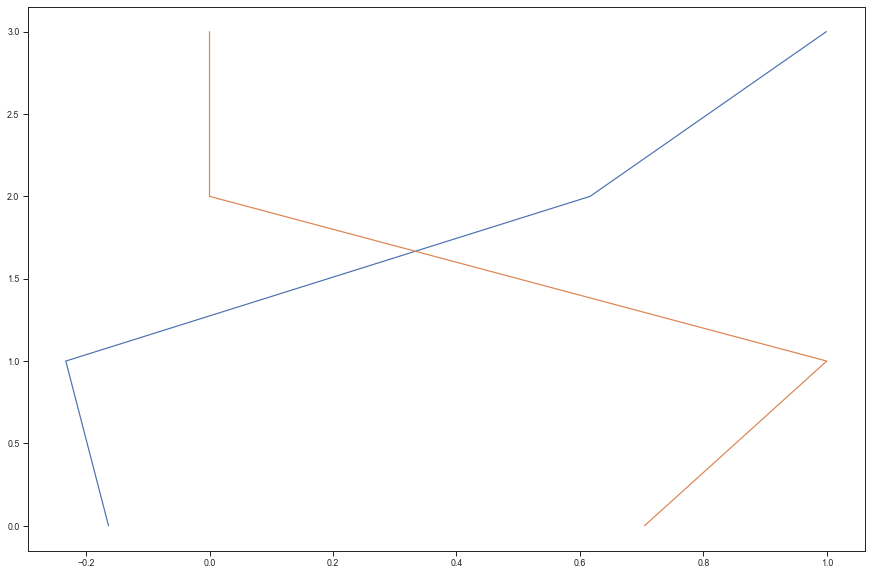

In [15]:
j = 0
print(true_phi[:,:,0])
print(phis_out[0][j,:])
print(MAC(true_phi[j,:,0],phis_out[0][j,:]))

fig, axs = plt.subplots(figsize=(15,10))
axs.plot(np.real(phis_out[0][j,:]),range(4))
axs.plot(np.real(true_phi[j,:,0]),range(4))

In [62]:
def n_skipped_time_seg_clustering(freqs_out, phis_out, true_freqs, true_phi, lim = 0.01):
    n = np.zeros_like(true_freqs[0])
    for k, freqs_out_k in enumerate(freqs_out):
        for j, freqs_out_kj in enumerate(freqs_out_k):
            phis_out_kj = phis_out[k][j,:]
            d_temp = np.array([])
            for i, true_mode_freq_i in enumerate(true_freqs[k]):
                true_phi_i = true_phi[i,:,k]
                d_temp = np.append(d_temp, rel_diff(true_mode_freq_i, freqs_out_kj) + 1 - MAC(true_phi_i, phis_out_kj))
            id_min = np.argmin(d_temp)
            if d_temp[id_min] <= lim:
                continue
            else:
                n[id_min] += 1
    return n

In [109]:
id_sort = np.argsort(true_w[0])
true_w_sorted = true_w[:,id_sort]
true_phi_sorted = true_phi[id_sort,:,:]
true_f_sorted = true_w_sorted/(2*np.pi)
freqs_out = rad2toHz(lambds_out)

In [72]:
n_skipped_clustering = n_skipped_time_seg_clustering(freqs_out, phis_out, true_f_sorted, true_phi_sorted, lim = 0.2)
print(n_skipped_clustering)

[25. 23.  8. 11.]


In [113]:
n_test = np.array([20,25,30,35,40])
m_test = np.array([5,8,11,14,17,20,23])
d_track_threshold_test = np.array([0.01, 0.05, 0.10, 0.20, 0.30, 0.35, 0.50])
result_dict = {}

In [116]:
for ni in n_test:
    for mi in m_test:
        for d_track_threshold_i in d_track_threshold_test:
            mode_traces_i = tk.perform_tracking(freqs_out, phis_out, n = ni, m = mi, d_track_threshold=d_track_threshold_i,method='average')
            n_skipped_clustering = n_skipped_time_seg_clustering(freqs_out[ni:], phis_out[ni:], true_f_sorted[ni:], true_phi_sorted[:,:,ni:], lim = d_track_threshold_i)
            if len(mode_traces_i) != 4:
                result_dict[ni, mi, d_track_threshold_i] = None
            else:
                temp_n_skipped_time_seg = []
                temp_error = []
                temp_time_seg = []
                temp_frequencies = []
                for k, mode_traces_ik in enumerate(mode_traces_i):
                    mode_traces_ik.set_error(true_w_sorted[:,k]/(2*np.pi))
                    temp_n_skipped_time_seg.append(mode_traces_ik.n_skipped_time_seg) 
                    temp_error.append(mode_traces_ik.error)
                    temp_time_seg.append(mode_traces_ik.time_seg)
                    temp_frequencies.append(mode_traces_ik.frequencies)
                result_dict[ni, mi, d_track_threshold_i] = temp_time_seg, temp_frequencies, temp_error, temp_n_skipped_time_seg - n_skipped_clustering


In [117]:
np.savez('result_average', result_dict=result_dict)

### Analysize Results

In [125]:
result_average = np.load('result_average.npz', allow_pickle=True)['result_dict'].item()
result_linear_extrapolation = np.load('result_linear_extrapolation.npz', allow_pickle=True)['result_dict'].item()

In [87]:
def plot_tracking_result(result_dict, true_f_sorted, n, m, d_track_threshold):
    fig, axs = plt.subplots(1,2, figsize = (20,10), tight_layout = True)
    ax_error = axs[1].twinx()
    n_modes = len(result_dict[n,m,d_track_threshold][3])
    error = []
    for i in range(n_modes):
        axs[0].scatter(result_dict[n,m,d_track_threshold][0][i], result_dict[n,m,d_track_threshold][1][i],label = 'Mode trace {}'.format(i+1))
        axs[0].plot(np.arange(0,true_f_sorted.shape[0]-n), true_f_sorted[n:,i])
        error.append(np.sum(result_dict[n,m,d_track_threshold][2][i]))
    axs[1].bar([1,2,3,4], result_dict[n,m,d_track_threshold][3],color = 'g',label='Number of time segments a mode trace did not find a mode')
    ax_error.bar([1,2,3,4], error, color = 'red', alpha = 0.5, label='Error sum')
    axs[0].legend()
    axs[1].legend(loc = 'upper left')
    ax_error.legend()
    plt.show()

In [112]:
print(0.15 + 1 - 0.8)

0.34999999999999987


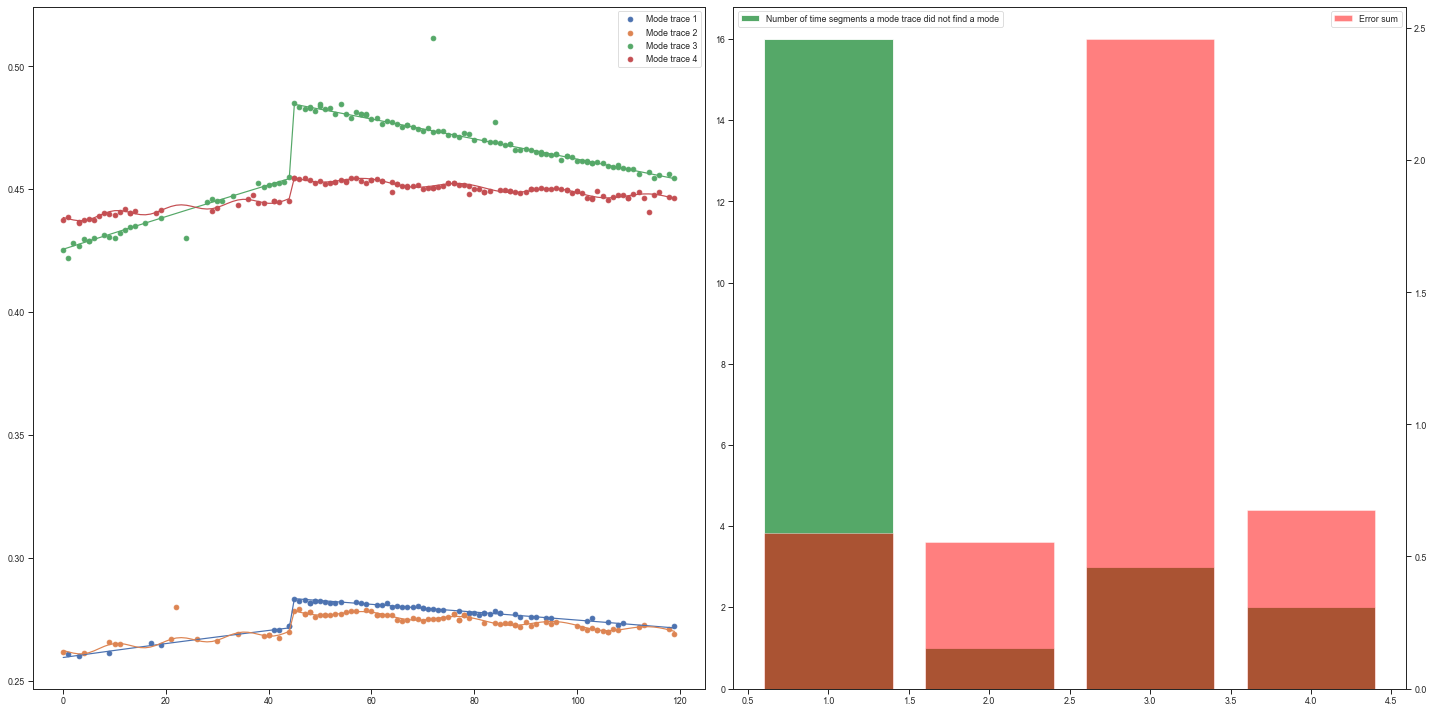

In [145]:
n = 30
m = 11
d_track_threshold = 0.10
plot_tracking_result(result_average, true_f_sorted, n, m, d_track_threshold)

In [146]:
n_plot = 30
error_tot = np.zeros((m_test.shape[0], d_track_threshold_test.shape[0]))
n_missed_tot = np.zeros((m_test.shape[0], d_track_threshold_test.shape[0]))
for i, mi in enumerate(m_test):
    for j, d_track_threshold_j in enumerate(d_track_threshold_test):
        error_ij = result_average[n_plot, mi, d_track_threshold_j][2]
        n_missed_ij = result_average[n_plot, mi, d_track_threshold_j][-1]
        n_missed_tot[i,j] += np.sum(n_missed_ij)
        for error in error_ij:
            error_tot[i,j] += np.sum(error)


[[0.01995743 2.03915802 4.24339524 4.89010806 5.2364409  5.37836729
  5.86025182]
 [0.01559222 1.97945495 4.18777213 4.83181267 5.19159204 5.35013596
  5.76036691]
 [0.01559222 1.93510156 4.2790308  4.85799687 5.36586496 5.46804895
  5.76850277]
 [0.01559222 1.94417611 3.94940485 4.81281893 5.37586911 5.50255
  5.78310176]
 [0.01559222 1.1836343  3.88405203 4.82897269 5.37644931 5.51116919
  5.78652492]
 [0.01559222 1.09501751 4.10028068 4.93763125 5.39584078 5.50389091
  5.78376759]
 [0.01559222 1.19372755 4.15645113 4.86457184 5.38209508 5.46294335
  5.7284227 ]]
[[144. 103.  25.  39.  37.  37.  39.]
 [145. 107.  25.  40.  42.  40.  42.]
 [145. 108.  22.  36.  32.  28.  42.]
 [145. 106.  39.  36.  33.  28.  40.]
 [145. 157.  32.  35.  32.  30.  39.]
 [145. 164.  29.  33.  29.  28.  39.]
 [145. 158.  26.  35.  30.  32.  40.]]


<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class 'matplotlib.text.Text'>
<class '

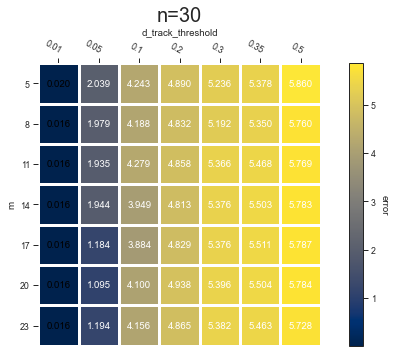

In [151]:
im_temp = plot_result_heatmap(error_tot, m_test, d_track_threshold_test, 'n='+str(n_plot))
plt.show(im_temp)

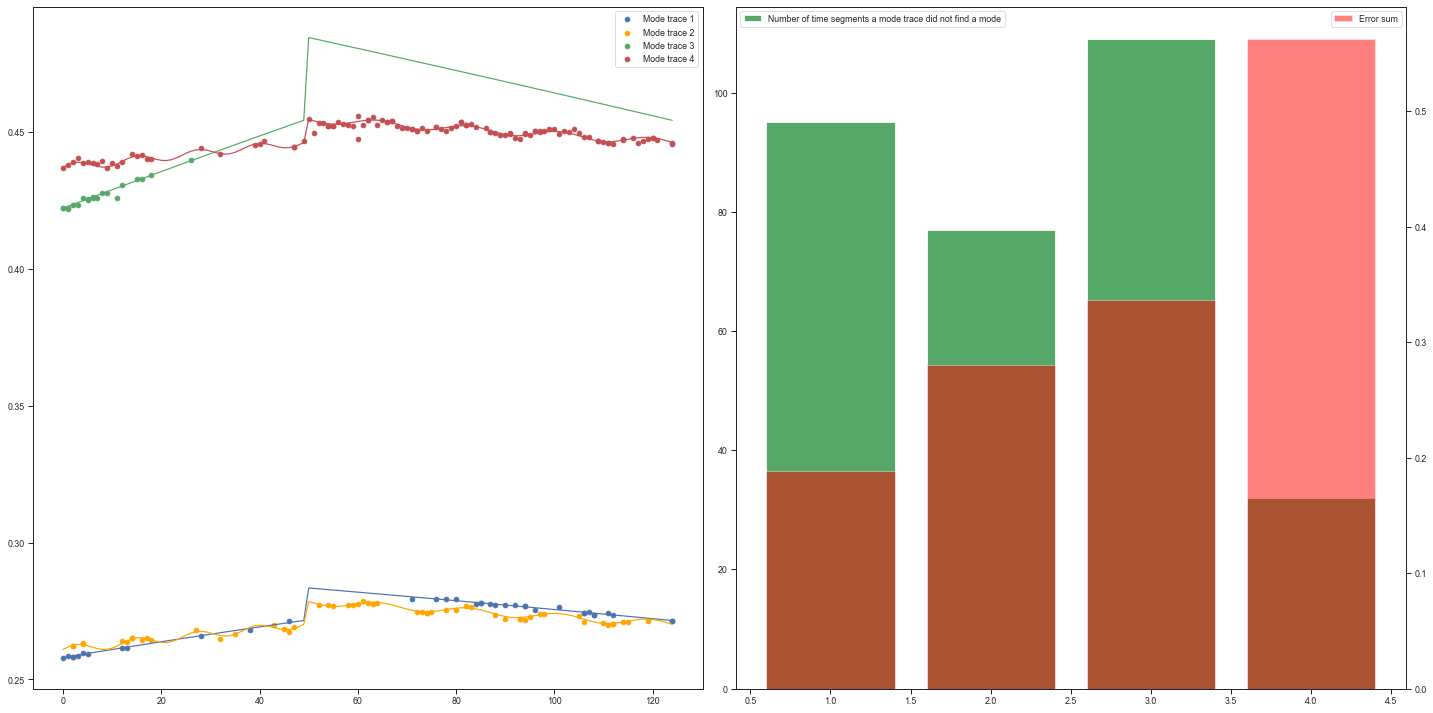

In [238]:
fig, axs = plt.subplots(1,2, figsize = (20,10), tight_layout = True)
ax_error = axs[1].twinx()
axs[0].scatter(result_dict[25,5,0.05][0][0], result_dict[25,5,0.05][1][0],label = 'Mode trace 1',color = 'b')
axs[0].scatter(result_dict[25,5,0.05][0][1], result_dict[25,5,0.05][1][1],label = 'Mode trace 2',color = 'orange')
axs[0].scatter(result_dict[25,5,0.05][0][2], result_dict[25,5,0.05][1][2],label = 'Mode trace 3',color = 'g')
axs[0].scatter(result_dict[25,5,0.05][0][3], result_dict[25,5,0.05][1][3],label = 'Mode trace 4',color = 'r')
axs[0].plot(np.arange(0,true_w_sorted.shape[0]-25), true_w_sorted[25:,0]/(2*np.pi), color = 'b')
axs[0].plot(np.arange(0,true_w_sorted.shape[0]-25), true_w_sorted[25:,1]/(2*np.pi), color = 'orange')
axs[0].plot(np.arange(0,true_w_sorted.shape[0]-25), true_w_sorted[25:,2]/(2*np.pi), color = 'g')
axs[0].plot(np.arange(0,true_w_sorted.shape[0]-25), true_w_sorted[25:,3]/(2*np.pi), color = 'r')
axs[1].bar([1,2,3,4], result_dict[25,5,0.05][3],color = 'g',label='Number of time segments a mode trace did not find a mode')
ax_error.bar([1,2,3,4], [np.sum(result_dict[25,5,0.05][2][0]),np.sum(result_dict[25,5,0.05][2][1]),np.sum(result_dict[25,5,0.05][2][2]),np.sum(result_dict[25,5,0.05][2][3])],color = 'red',alpha = 0.5,label='Error sum')
axs[0].legend()
axs[1].legend(loc = 'upper left')
ax_error.legend()